# Lindblad simulation notebook

Useful literature:

- [1] T. Prosen, "Exact nonequilibrium steady state of a strongly driven open XXZ chain", arXiv:1106.2978, https://arxiv.org/abs/1106.2978 (2011)
- [2] R. Cleve, C. Wang, "Efficient Quantum Algorithms for Simulating Lindblad Evolution", arXiv:1612.09512, https://arxiv.org/abs/1612.09512 (2016)
- [3] H. Chen et al., "A Randomized Method for Simulating Lindblad Equations and Thermal State Preparation", arXiv:2407.06594v2, https://arxiv.org/abs/2407.06594v2 (2024)
- [4] Z. Ding et al. "Simulating Open Quantum Systems Using Hamiltonian Simulations", arXiv:2311.15533, https://arxiv.org/abs/2311.15533 (2023)
- [5] Brunner et al. "Lindblad engineering for quantum Gibbs state preparation under the eigenstate thermalization hypothesis", arXiv:2412.17706, https://arxiv.org/abs/2412.17706 (2024)
- [6] T. Prosen, I. Pizorn, "Quantum phase transition in a far from equilibrium steady state of XY spin chain", arXiv:0805.2878, https://arxiv.org/abs/0805.2878 (2008)
- [7] J. Jin et al., "Cluster mean-field approach to the steady-state phase diagram of dissipative spin systems", arXiv:1602.06553, https://arxiv.org/abs/1602.06553 (2016)

This is the Lindblad part of the iquhack25 Quantinuum challenge. The aim is to implement the dynamics of a dissipative quantum system (i.e. an open system coupled to an environment), which is described by a Lindbladian $\mathcal{L}$. In comparison to this, a quantum systems is described by a Hamiltonian $H$, as we saw in the notebook `notebooks/hamiltonian_simulation.ipynb`. 

As an example we consider the system studied in [1]. The system is a XXZ Heisenberg spin chain, coupled to an environment at the edges of the chain.

In [24]:
# configure some visualisations
from pytket.circuit import CircBox, Circuit, Qubit
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit.display import get_circuit_renderer
from pytket.utils.expectations import get_operator_expectation_value
from pytket.circuit.display import render_circuit_jupyter as draw
import numpy as np
circuit_renderer = get_circuit_renderer()

circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()

## Background

The Lindbladian is a "supoeroperator", acting on a quantum state $\rho$ by
$$
\mathcal{L}[\rho]
= -i [H, \rho] + \mathcal{D} [\rho]
= -i [H, \rho] + \sum_{i = 1}^S \mathcal{D}_i [\rho] \,,
\quad \text{with} \quad
\mathcal{D}_i [\rho] = L_i \rho L_i^\dagger - \frac{1}{2} \lbrace L_i^\dagger L_i, \rho \rbrace \,,
$$
where $S$ is the number of jump operators.
The first term is the coherent part, describing coherent (unitary) evolution under the system Hamiltonian, the second part is the dissipative part describing the interaction of the system with the environment.
The Lindbladian $\mathcal{L}$ generates a Lindbladian (or dissipative) time evolution given by
$$
\rho(t) = e^{t \mathcal{L}} [\rho(0)] \,,
$$
where $\rho(0)$ is the initial state.

The notation $\rho$ instead of $\ket{\psi}$ indicates that we are working with mixed quantum states now, which is slightly more general. You don't need to know what mixed states are for this challenge. For now just assume we use a different symbol than $\ket{\psi}$ for the quantum state in this notebook. Explicit circuit pictures are given below.

The time evolution under the Lindbladian $\mathcal{L}$ is implemented (similar to Trotterization) by means of a product formula, factorizing the coherent and dissipative parts.
Let $T$ be the target evolution time. We disretize the time interval $[0,T]$ into $M \in \mathbb{N}$ equidistant time steps of size $\Delta t = T / M$.
The time evolution up to time $T = M \Delta t$ is approximated by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
i.e. we factorize the coherent and dissipative parts. In each time step, we concatenate coherent evolution for $\Delta t$ with the dissipative evolution for time $\Delta t$.

A mixed state $\rho$ is a matrix representation of the quantum state, in contrast to $\ket{\psi}$ which is a vector representation of a quantum state. Therefore, $\rho$ is also called density matrix, and time evolution acts on it by acting with the time evolution operator on both sides as in the formula above. This does not change the quantum circuit that we have to implement. Explicit quantum circuit pictures are given below.

### The dissipative XXZ Heisenberg model

We consider the model proposed in [1]. The Hamiltonian of the dissipative system is given by the XXZ Heisenberg model, which we already know from the other notebook `notebooks/hamiltonian_simulation.ipynb`. It is given by
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)} \,.
$$
Here $\sigma_{\pm} = \frac{1}{2}(X \pm i Y)$ and, as before $A^{(k)} = I \otimes \cdots \otimes I \otimes A \otimes I \otimes \cdots \otimes I$, where $A \in \lbrace X, Y, Z, \sigma_+, \sigma_- \rbrace$ is inserted on the $k$-th position, i.e. it is acting on the $k$-th qubits. Identities $I$ mean that no operations are performed on those qubits.

The first two terms describe hopping of a spin between neighboring sites, the third term, quantified by $\Delta$, describes the repulsive interaction of two adjacent spins.

We can recast this Hamiltonian into
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)}
= \sum_{j = 1}^{N-1} X^{(j)} X^{(j+1)} + Y^{(j)} Y^{(j+1)} + \Delta Z^{(j)} Z^{(j+1)} \,,
$$
which is the form of the XXZ Heisenberg model which we already used in `notebooks/hamiltonian_simulation.ipynb`.


The dissipative character of the system is modelled by the jump operators. In this case we only have two of them, one on each side of the chain.
They are given by $L_1 = \sqrt{2\epsilon} \sigma^{(1)}_+$ and $L_2 = \sqrt{2\epsilon} \sigma^{(N)}_-$.
The jump operator $L_1$ models qubit excitations that are injected from the environment into the spin chain from the left. The operator $L_2$ describes how those excitations are transmitted from the right end of the chain back into the environment. One task of this challenge is to reproduce the spin profile given in Fig. 2 of [1], showing the expected spin excitation imbalance from left to right.

Below we give a detailed description of the Lindblad simulation algorithm, which is based out of two parts that are applied sequentially: (i) The coherent time evolution we already studied in `notebooks/hamiltonian_simulation.ipynb`, and (ii) the dissipative part, which is new. If you want read more on this, and how it is applied in different situations, see e.g. Fig. 1 in [4], Sec. IV and App. B in [5], or relevant parts of [2,3]. This literature is, however, not necessary for the tasks below.

### Implementation of the coherent part

Let us start with the coherent part $\mathcal{U}_{\Delta t}$ of the Lindbladian. The first term of the Lindbladian $-i[H, \rho]$ generates the unitary evolution of the system under the evolution operator $\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H}$. This part can be implemented via Trotterisation, which we studied in the notebook `notebooks/hamiltonian_simulation.ipynb`.


### Implementation of the dissipative part

The dissipative part is implemented via a so-called dilation of the jump operators, which requires an additional ancilla qubits which will be traced out later.
The dilation of the jump operator $L_i$ for our system, as proposed in [1], is given by
$$
K_i 
= \ket{1}\bra{0}_\mathrm{anc} \otimes L_i + \ket{0}\bra{1}_\mathrm{anc} \otimes L_i^\dagger 
= X_\mathrm{anc} \otimes \frac{L_i + L_i^\dagger}{2} - i Y_\mathrm{anc} \otimes \frac{L_i - L_i^\dagger}{2} \,.
$$


We wish to generate the Lindblad simulation circuit. One step for this is building the dilation operator, which is a Hermitian operator. This can be simulated with Hamiltonian simulation via Trotterization.

Let's consider our jump operators. We have $L_1 + L_1^\dagger = \sqrt{2\epsilon} X^{(1)}$ and $L_1 - L_1^\dagger = i \sqrt{2\epsilon} Y^{(1)}$. For the second jump operator we have $L_2 + L_2^\dagger = \sqrt{2\epsilon} X^{(N)}$ and $L_2 - L_2^\dagger = -i\sqrt{2\epsilon} Y^{(N)}$. Therefore, in our case the dilation is given by
$$
\begin{split}
K_1 
&= X^\mathrm{(anc)}  \frac{\sqrt{2\epsilon}}{2} X^{(1)} - i Y^\mathrm{(anc)}  i \frac{\sqrt{2\epsilon}}{2} Y^{(1)}
= \frac{\sqrt{2\epsilon}}{2} X^\mathrm{(anc)}  X^{(1)} + \frac{\sqrt{2\epsilon}}{2} Y^\mathrm{(anc)}  Y^{(1)} 
= K_1^1 + K_1^2 \\
K_2
&= X^\mathrm{(anc)}  \frac{\sqrt{2\epsilon}}{2} X^{(N)} - i Y^\mathrm{(anc)}  (-1) i \frac{\sqrt{2\epsilon}}{2} Y^{(N)}
= \frac{\sqrt{2\epsilon}}{2} X^\mathrm{(anc)}  X^{(N)} - \frac{\sqrt{2\epsilon}}{2} Y^\mathrm{(anc)}  Y^{(N)}
= K_2^1 + K_2^2 \,.
\end{split}
$$

##### Deterministic protocol:

To implement the dissipative part of the dynamics, we need to perform Hamiltonian simulation of the dilation operators $K_i$. After one step of time evolution, we have to trace out the ancilla qubit and reset it, to ensure that our circuit performs the targeted dynamical step.

This is accomplished by the following:
$$
\begin{split}
    &\mathrm{tr}_{\rm anc_1 anc_2} \big[ 
        e^{-i\sqrt{ \Delta t} K_1} e^{-i\sqrt{ \Delta t} K_{2}} 
        (\ket{0}\bra{0}_{\rm anc_1} \otimes\dots\otimes \ket{0}\bra{0}_{\rm anc_2} \otimes \rho) 
        e^{i\sqrt{ \Delta t} K_1} e^{i\sqrt{ \Delta t} K_{2}} 
    \big] 
    \\
    &= 
    e^{\Delta t \mathcal{D}}[\rho] + {\cal O}( \Delta t^2) \,.
\end{split}
$$

which can be visualized by the circuit

<img src="../circuit_pictures/deterministic_protocol.png" alt="drawing" width="500"/>



This implementation results in an error, similar to the second order Trotterization error which we studied in `notebooks/hamiltonian_simulation.ipynb`, of order $\Delta t^2$.

##### Randomized single-ancilla protocol (alternative approach):

The above protocol can be randomized. That means that in each time step, we select on of the jump operators at random, and only apply the corresponding dilated operator.
This means, that we approximate the time evolution up to time $T = M \Delta t$ by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
= \left( \prod_{i = 1}^M e^{S \Delta t \mathcal{D}_{a_i}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
where in each time step $i$ we randomly select one of the jump operators $L_{a_i}$ and apply the corresponding single-jump dissipator $\mathcal{D}_{a_i}$. Note the number of jump operators $S$ appearing in the exponent $e^{S \Delta t \mathcal{D}_{a_i}}$.

With this approach we only need a single ancilla qubit, and each time step is implemented with a shallower circuit as in the deterministic approach. This comes at the cost of inducing an additional error through randomization. This error needs to be controlled by running several "random runs" of the algorithm, and averaging the results.
Based on the dilation, the evolution under the dissipator $\mathcal{D}_i$ is approximately implemented via
$$
\mathrm{tr}_\mathrm{anc} \left[ e^{ -i \sqrt{S \Delta t}K_i} \left( \ket{0}\bra{0}_\mathrm{anc} \otimes \rho \right) e^{ i \sqrt{S \Delta t}K_i} \right]
= e^{S \Delta t \mathcal{D}_{a_i}} [\rho] + \mathcal{O}(\Delta t^2) \,,
$$
which induce an error of order $\Delta t^2$.

<img src="../circuit_pictures/randomized_protocol.png" alt="drawing" width="500"/>


Hint: In the following we suggest to first start with the deterministic protocol, but you can also explore the randomized version of the algorithm as an alternative.

## Circuit implementation

### Task 1: Construct Hamiltonian and Hamiltonian simulation circuit

As in `notebooks/hamiltonian_simulation.ipynb`, we give the implementation of the Hamiltonian as QubitPauliOperator. Construct the corresponding Hamiltonian simulation circuit (if you have not already done this in the first part of the challenge).

Note that the Hamiltonian can be reformulated into
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)}
= \sum_{j = 1}^{N-1} X^{(j)} X^{(j+1)} + Y^{(j)} Y^{(j+1)} + \Delta Z^{(j)} Z^{(j+1)} \,,
$$
which is the form of the XXZ Heisenberg model which we already used in `notebooks/hamiltonian_simulation.ipynb`. Check that this is indeed the case.

Hint: As you know from the other notebook, the terms of the Hamiltonian commute, so you only need to do a single Trotter step of size $t$ to reach a target time $t$.

In [13]:
import networkx as nx
import math
from pytket.circuit import Qubit, Circuit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator, gen_term_sequence_circuit
from pytket.utils import QubitPauliOperator

def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0

    return QubitPauliOperator(qpo_dict)

n_system_qubits = 4
Delta_ZZ = 0.5
n_trotter_coherent = 5
t_trotterization = 10
xxz_hamiltonian = get_xxz_chain_hamiltonian(n_qubits=n_system_qubits, Delta_ZZ=Delta_ZZ)

In [14]:
def get_hamiltonian_simulation_circbox(
    hamiltonian: QubitPauliOperator,
    n_qubits: int,
    t_trotterization: float,
    n_trotter_steps: int,
):
    trotter_step_size = t_trotterization / n_trotter_steps

    # Bug in docstring of gen_term_sequence_circuit -> no minus required!
    scaled_hamiltonian = trotter_step_size * (2 / np.pi) * hamiltonian

    time_evo_circ = Circuit(n_qubits=n_qubits, name="Time evolution")
    base_circ = Circuit(n_qubits=n_qubits)
    trotter_circ = gen_term_sequence_circuit(
        scaled_hamiltonian, reference_state=base_circ
    )
    trotter_circ.name = "Trotter step"
    trotter_box = CircBox(trotter_circ)
    for _ in range(n_trotter_steps):
        time_evo_circ.add_circbox(trotter_box, range(n_qubits))

    return CircBox(time_evo_circ)


### Task 2: Construct the evolution under the dilated Lindblad operators $K_i$

Now we look at the dissipative part.

Implement the time evolution under the dilated operators $K_i$ for a time of $\Delta t$ according to
$$
\begin{split}
    &\mathrm{tr}_{\rm anc_1 anc_2} \big[ 
        e^{-i\sqrt{ \Delta t} K_1} e^{-i\sqrt{ \Delta t} K_{2}} 
        (\ket{0}\bra{0}_{\rm anc_1} \otimes\dots\otimes \ket{0}\bra{0}_{\rm anc_2} \otimes \rho) 
        e^{i\sqrt{ \Delta t} K_1} e^{i\sqrt{ \Delta t} K_{2}} 
    \big] 
    \\
    &= 
    e^{\Delta t \mathcal{D}}[\rho] + {\cal O}( \Delta t^2) \,.
\end{split}
$$

Hints:
- For the deterministic protocol we will need to add two ancilla qubits.
- Study the commutator relation between the two terms of $K_i$. What does this imply?
- The two qubit gates $e^{-\alpha X^{(i)} X^{(j)}}$ and $e^{-\alpha Y^{(i)} Y^{(j)}}$ can be efficiently implemented in pytket via `XXPhase` and `YYPhase`.
- However, you can also use `gen_term_sequence_circuit()`, or pytket's `TK2` gate which implements and arbitrary angle two-qubit gate.
- Use pytket's .reset() operation to trace out the ancilla qubits after one time step of size $\Delta t$.

In [18]:
n_ancilla_qubits = 2
n_system_qubits = n_system_qubits

circ = Circuit()
anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
sys_reg = circ.add_q_register("system", n_system_qubits)

In [19]:
def get_dilation_step_deterministic(dilation_angles: dict, n_qubits: int):
    circ = Circuit(name="Dilation Trotter step")
    qreg_anc = circ.add_q_register("anc_dilation", 2)
    qreg_sys = circ.add_q_register("sys", n_qubits)

    circ.TK2(*dilation_angles["K1"], qreg_anc[0], qreg_sys[0])
    circ.TK2(*dilation_angles["K2"], qreg_anc[1], qreg_sys[n_qubits - 1])
    box = CircBox(circ)

    return box

def get_dilation_angles(epsilon, Delta_t):
    angles_K1 = [
        (2 / np.pi) * (np.sqrt(2 * epsilon) / 2) * np.sqrt(Delta_t),
        (2 / np.pi) * (np.sqrt(2 * epsilon) / 2) * np.sqrt(Delta_t),
        0.0,
    ]
    angles_K2 = [
        (2 / np.pi) * (np.sqrt(2 * epsilon) / 2) * np.sqrt(Delta_t),
        -(2 / np.pi) * (np.sqrt(2 * epsilon) / 2) * np.sqrt(Delta_t),
        0.0,
    ]
    dilation_angles = {
        "K1": angles_K1,
        "K2": angles_K2,
    }
    return dilation_angles

def get_dissipator_simulation_circbox_deterministic(
    epsilon: float, n_system_qubits: int, t_dissipator: float, n_trotter_steps: int
):
    trotter_step_size = t_dissipator / n_trotter_steps

    dilation_angles = get_dilation_angles(epsilon, Delta_t=trotter_step_size)
    dilation_trotter_step = get_dilation_step_deterministic(
        dilation_angles, n_system_qubits
    )

    circ = Circuit(name="Dissipator Trotterization")
    anc_reg = circ.add_q_register("ancilla", 2)
    sys_reg = circ.add_q_register("system", n_system_qubits)

    for _ in range(n_trotter_steps):
        circ.add_circbox(dilation_trotter_step, anc_reg.to_list() + sys_reg.to_list())
    circ.Reset(anc_reg[0])
    circ.Reset(anc_reg[1])

    return CircBox(circ)


In [20]:
epsilon = 0.2
delta_t_evolution = 1.0
n_evolution_steps = 1

coherent_box = get_hamiltonian_simulation_circbox(
    xxz_hamiltonian,
    n_system_qubits,
    t_trotterization=delta_t_evolution,
    n_trotter_steps=1,
)
dissipative_box_deterministic = get_dissipator_simulation_circbox_deterministic(
    epsilon,
    n_system_qubits=n_system_qubits,
    t_dissipator=delta_t_evolution,
    n_trotter_steps=1,
)

# for _ in range(n_evolution_steps):
circ.add_circbox(coherent_box, sys_reg.to_list())
circ.add_circbox(
    dissipative_box_deterministic, anc_reg.to_list() + sys_reg.to_list()
)
draw(circ)

### Task 3: Building the full circuit

As given above, the full time evolution up to time $T = M \Delta t$ is approximated by decomposing the time evolution into $M$ steps of size $\Delta t$, in each of which we separate coherent and dissipative parts
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
(see also the circuit picture above).

- Use the coherent and dissipative parts from above to generate a circuit implementing $M$ steps of Eq. (1).
- Construct the full Lindblad time evolution circuit as a function of $N$, $M$, $T$, $\epsilon$ and $\Delta_{ZZ}$.
- Compile the circuit and compute 2qb-gate counts for varied $M$. What are reasonable total evolution times $T$ and step sizes $\Delta t = T / M$?
- Use and empty circuit to initialize the time evolution. This means we are starting with the state where all qubits are in the zero state $\rho = \ket{0}\bra{0}^{\otimes N}$.

In [68]:
def XXZ_lindblad_simulation_circ(
    n_system_qubits: int,
    Delta_ZZ: float,
    epsilon: float,
    t_evolution: float,
    n_evolution_steps: int,
) -> Circuit:
    delta_t_evolution = t_evolution / n_evolution_steps
    n_ancilla_qubits = 2

    xxz_hamiltonian = get_xxz_chain_hamiltonian(
        n_qubits=n_system_qubits, Delta_ZZ=Delta_ZZ
    )

    coherent_box = get_hamiltonian_simulation_circbox(
        xxz_hamiltonian,
        n_system_qubits,
        t_trotterization=delta_t_evolution,
        n_trotter_steps=1,
    )
    dissipative_box_deterministic = get_dissipator_simulation_circbox_deterministic(
        epsilon,
        n_system_qubits=n_system_qubits,
        t_dissipator=delta_t_evolution,
        n_trotter_steps=1,
    )

    circ = Circuit()
    anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
    sys_reg = circ.add_q_register("system", n_system_qubits)
    for _ in range(n_evolution_steps):
        circ.add_circbox(coherent_box, sys_reg.to_list())
        circ.add_circbox(
            dissipative_box_deterministic, anc_reg.to_list() + sys_reg.to_list()
        )

    return circ


### Task 4: Compute the steady state of the dissipative XXZ Heisenberg model.

- Simulate the circuit and generate the spin profile, as in Fig. 2 of [1], for a reasonable small number $N$ of qubits, e.g. $N \in [4,5,6]$.
- At the end of a sufficiently long time evolution, measure the expectation values of $Z^{(i)}$ for $i = 1,\dots, N$. A number of `n_shots = 300` shots should be sufficient for this. Plot the measured expectation values as a function of $i$.
- You should get something similar as the left plot in Fig. 2 of [1], although for much smaller $N$. How do you interpret the results?

Hints:
- Use the setting $N = 5$, $M = 30$, $T = 100$, $\epsilon = 0.2$ and $\Delta_{ZZ} = 0.5$. If you implemented everything correctly, you should obtain a reasonable spin profile with this. This setting should not take longer than a minute to run.
- From the Hamiltonian simulation notebook you should already be familiar with how to simulate quantum circuits, e.g. using the `AerBackend`.
- Compiling the circuit with a higher optimization level takes a bit but will mostly also result in a much shorter circuit, i.e. faster simulation. Check the 2-qubit gate counts for different optimization levels.


Numerical values of Z expectations for ΔZZ = 0.5:
Qubit 1: 1.000
Qubit 2: 0.453
Qubit 3: 0.373
Qubit 4: 0.027
Qubit 5: -0.980


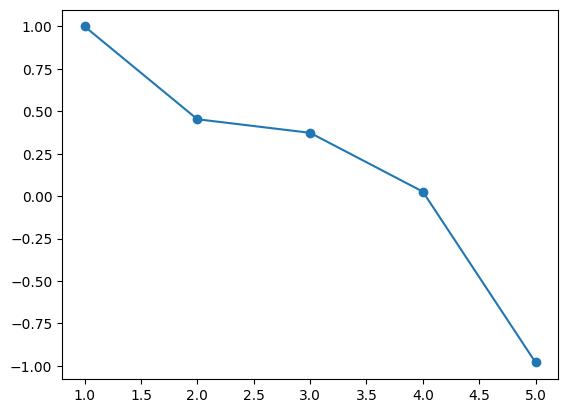

In [30]:
import matplotlib.pyplot as plt
from pytket.backends.backend import Backend
from pytket.extensions.qiskit import AerBackend

# Function to measure Z expectations for all qubits
def measure_z_expectations(circuit, n_qubits, n_shots=300):
    expectations = []
    for i in range(n_qubits):
        # Create Z observable for qubit i
        observable = QubitPauliOperator({QubitPauliString([Qubit('system', i)], [Pauli.Z]): 1.0})
        # Measure expectation value
        expectation = get_operator_expectation_value(circuit, observable, backend, n_shots).real
        expectations.append(expectation)
    return expectations

# Initialize backend
backend = AerBackend()

n_qubits = 5

sim_circuit = XXZ_lindblad_simulation_circ(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)

z_expectations = measure_z_expectations(sim_circuit, n_qubits)

plt.plot(range(1, n_qubits + 1), z_expectations, 'o-', 
            label=f'ΔZZ = {0.5}')

# Print numerical values
print(f"\nNumerical values of Z expectations for ΔZZ = {0.5}:")
for i, exp in enumerate(z_expectations, 1):
    print(f"Qubit {i}: {exp:.3f}")

### Task 5: Explore other parameter choices

What happens if you choose larger time steps $\Delta t$, i.e. smaller $M$. Is there a minimum value for $M$ to get reasonable results? You can also explore other parameter settings, i.e. larger $\Delta_{ZZ}$ (the $ZZ$ interaction in the Hamiltonian) or larger $\epsilon$ (which controls the interaction between the boundary qubits and the environment). What would you expect for very large or very small $\epsilon$?


Numerical values of Z expectations for M = 10
Qubit 1: 0.753
Qubit 2: -0.427
Qubit 3: 0.580
Qubit 4: -0.660
Qubit 5: -0.767

Numerical values of Z expectations for M = 20
Qubit 1: 1.000
Qubit 2: 0.900
Qubit 3: 0.300
Qubit 4: -0.887
Qubit 5: -1.000

Numerical values of Z expectations for M = 30
Qubit 1: 0.993
Qubit 2: 0.487
Qubit 3: 0.320
Qubit 4: 0.047
Qubit 5: -0.987

Numerical values of Z expectations for M = 40
Qubit 1: 0.627
Qubit 2: -0.373
Qubit 3: 0.480
Qubit 4: -0.553
Qubit 5: -0.660


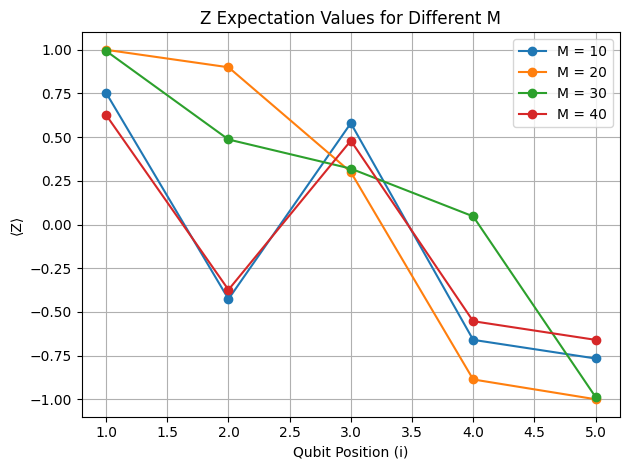

In [32]:
# Plot curves for different Delta_ZZ values
for m in [10, 20, 30, 40]:
    sim_circuit = XXZ_lindblad_simulation_circ(
        n_system_qubits=n_qubits,
        Delta_ZZ=0.5,
        epsilon=0.2,
        t_evolution=100,
        n_evolution_steps=m,
    )
    
    z_expectations = measure_z_expectations(sim_circuit, n_qubits)
    
    plt.plot(range(1, n_qubits + 1), z_expectations, 'o-', 
             label=f'M = {m}')
    
    # Print numerical values
    print(f"\nNumerical values of Z expectations for M = {m}")
    for i, exp in enumerate(z_expectations, 1):
        print(f"Qubit {i}: {exp:.3f}")

plt.xlabel('Qubit Position (i)')
plt.ylabel('⟨Z⟩')
plt.title('Z Expectation Values for Different M')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Numerical values of Z expectations for ΔZZ = 0.5:
Qubit 1: 0.987
Qubit 2: 0.460
Qubit 3: 0.380
Qubit 4: 0.053
Qubit 5: -0.993

Numerical values of Z expectations for ΔZZ = 1.0:
Qubit 1: 0.987
Qubit 2: 0.647
Qubit 3: 0.013
Qubit 4: -0.700
Qubit 5: -0.967

Numerical values of Z expectations for ΔZZ = 1.5:
Qubit 1: 1.000
Qubit 2: 0.940
Qubit 3: 0.647
Qubit 4: -0.440
Qubit 5: -0.980


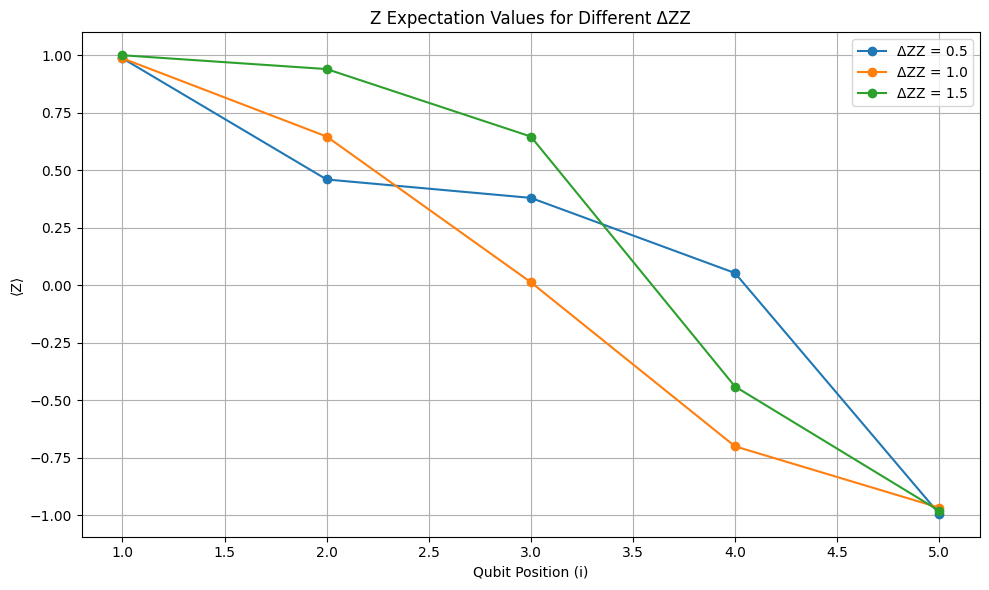

In [33]:
plt.figure(figsize=(10, 6))

for delta_zz in [0.5, 1.0, 1.5]:
    sim_circuit = XXZ_lindblad_simulation_circ(
        n_system_qubits=n_qubits,
        Delta_ZZ=delta_zz,
        epsilon=0.2,
        t_evolution=100,
        n_evolution_steps=30,
    )

    z_expectations = measure_z_expectations(sim_circuit, n_qubits)

    plt.plot(range(1, n_qubits + 1), z_expectations, 'o-', 
             label=f'ΔZZ = {delta_zz}')
    
    # Print numerical values
    print(f"\nNumerical values of Z expectations for ΔZZ = {delta_zz}:")
    for i, exp in enumerate(z_expectations, 1):
        print(f"Qubit {i}: {exp:.3f}")

plt.xlabel('Qubit Position (i)')
plt.ylabel('⟨Z⟩')
plt.title('Z Expectation Values for Different ΔZZ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Task 6: Comparison to Hamiltonian simulation

Next we compare the long time behavior of the output of the Lindbladian and the Hamiltonians time evolution circuits.

- Compute the spin profile for the same setting as above but using only Hamiltonian simulation.
- Compute the spin profile under both the Lindbladian and the Hamiltonian for some values of $T$ in the interval $[98, 102]$.
- Do the same for the $X$ spin profile, i.e. compute the expectation values of $X^{(i)}$ for $i =1,\dots, N$. You can also explore correlators $X^{(i)} X^{(j)}$.
- How do the solutions behave differently? Why is the long-time evolved state under the Lindbladian also called "steady state"?

In [34]:
def XXZ_hamiltonian_simulation_circ(
    n_system_qubits: int,
    Delta_ZZ: float,
    epsilon: float,
    t_evolution: float,
    n_evolution_steps: int,
) -> Circuit:
    delta_t_evolution = t_evolution / n_evolution_steps
    # n_ancilla_qubits = 2

    xxz_hamiltonian = get_xxz_chain_hamiltonian(
        n_qubits=n_system_qubits, Delta_ZZ=Delta_ZZ
    )

    coherent_box = get_hamiltonian_simulation_circbox(
        xxz_hamiltonian,
        n_system_qubits,
        t_trotterization=delta_t_evolution,
        n_trotter_steps=1,
    )
    # dissipative_box_deterministic = get_dissipator_simulation_circbox_deterministic(
    #     epsilon,
    #     n_system_qubits=n_system_qubits,
    #     t_dissipator=delta_t_evolution,
    #     n_trotter_steps=1,
    # )

    circ = Circuit()
    # anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
    sys_reg = circ.add_q_register("system", n_system_qubits)
    for _ in range(n_evolution_steps):
        circ.add_circbox(coherent_box, sys_reg.to_list())
        # circ.add_circbox(
        #     dissipative_box_deterministic, anc_reg.to_list() + sys_reg.to_list()
        # )

    return circ

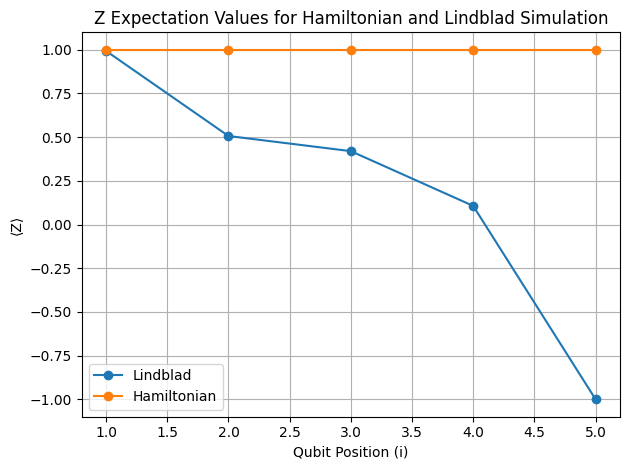

In [35]:
lb_circuit = XXZ_lindblad_simulation_circ(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)
hl_circuit = XXZ_hamiltonian_simulation_circ(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)
l_z_expectations = measure_z_expectations(lb_circuit, n_qubits, n_shots=30)
h_z_expectations = measure_z_expectations(hl_circuit, n_qubits, n_shots=30)
plt.plot(range(1, n_qubits + 1), l_z_expectations, 'o-', label='Lindblad')
plt.plot(range(1, n_qubits + 1), h_z_expectations, 'o-', label='Hamiltonian')
plt.xlabel('Qubit Position (i)')
plt.ylabel('⟨Z⟩')
plt.title('Z Expectation Values for Hamiltonian and Lindblad Simulation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
def measure_x_expectations(circuit, n_qubits, n_shots):
    expectations = []
    for i in range(n_qubits):
        # Create Z observable for qubit i
        observable = QubitPauliOperator({QubitPauliString([Qubit('system', i)], [Pauli.X]): 1.0})
        # Measure expectation value
        expectation = get_operator_expectation_value(circuit, observable, backend, n_shots).real
        expectations.append(expectation)
    return expectations

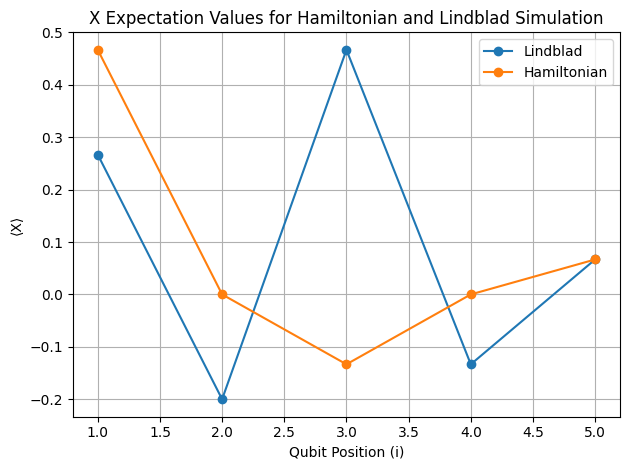

In [38]:
lb_circuit = XXZ_lindblad_simulation_circ(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)
hl_circuit = XXZ_hamiltonian_simulation_circ(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)
l_z_expectations = measure_x_expectations(lb_circuit, n_qubits, n_shots=30)
h_z_expectations = measure_x_expectations(hl_circuit, n_qubits, n_shots=30)
plt.plot(range(1, n_qubits + 1), l_z_expectations, 'o-', label='Lindblad')
plt.plot(range(1, n_qubits + 1), h_z_expectations, 'o-', label='Hamiltonian')
plt.xlabel('Qubit Position (i)')
plt.ylabel('⟨X⟩')
plt.title('X Expectation Values for Hamiltonian and Lindblad Simulation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Task 7: Influence of noise

How does hardware noise influence the results. Simulate the circui with some noise models, e.g. Quantinuum noise models.

In [ ]:
from pytket.extensions.qiskit import AerBackend, AerStateBackend
from pytket.extensions.qiskit.backends.aer import NoiseModel
from pytket.extensions.qiskit.backends.crosstalk_model import CrosstalkParams

from qiskit_aer.noise import depolarizing_error

# noise_model = CrosstalkParams().get_noise_model()
noise_model = NoiseModel()
d_error = depolarizing_error(0.001, 1)
for i in range(n_qubits):
    noise_model.add_quantum_error(d_error, ['x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'rx', 'ry', 'rz'], [i])

noise_backend = AerBackend(noise_model=noise_model)

In [48]:
def measure_z_expectations_noise(circuit, n_qubits, n_shots):
    expectations = []
    for i in range(n_qubits):
        # Create Z observable for qubit i
        observable = QubitPauliOperator({QubitPauliString([Qubit('system', i)], [Pauli.Z]): 1.0})
        # Measure expectation value
        expectation = get_operator_expectation_value(circuit, observable, noise_backend, n_shots).real
        expectations.append(expectation)
    return expectations

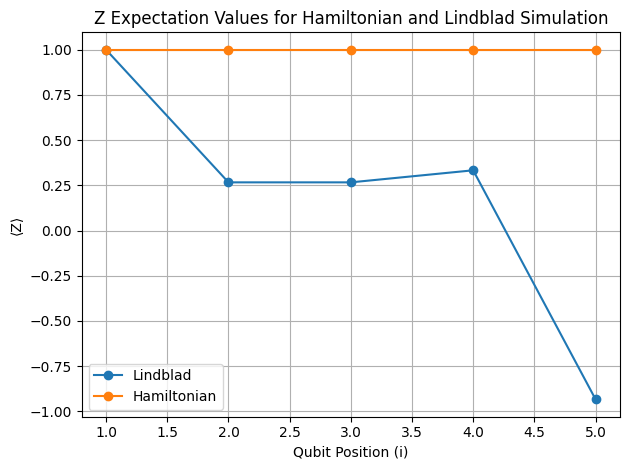

In [49]:
lb_circuit = XXZ_lindblad_simulation_circ(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)
hl_circuit = XXZ_hamiltonian_simulation_circ(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)
l_z_expectations = measure_z_expectations(lb_circuit, n_qubits, n_shots=30)
h_z_expectations = measure_z_expectations(hl_circuit, n_qubits, n_shots=30)
plt.plot(range(1, n_qubits + 1), l_z_expectations, 'o-', label='Lindblad')
plt.plot(range(1, n_qubits + 1), h_z_expectations, 'o-', label='Hamiltonian')
plt.xlabel('Qubit Position (i)')
plt.ylabel('⟨Z⟩')
plt.title('Z Expectation Values for Hamiltonian and Lindblad Simulation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Task 8: Study the randomized version of the algorithm

The above protocol can be randomized. That means that in each time step, we select on of the jump operators at random, and only apply the corresponding dilated operator.
This means, that we approximate the time evolution up to time $T = M \Delta t$ by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
= \left( \prod_{i = 1}^M e^{\Delta t S \mathcal{D}_{a_i}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
where in each time step $i$ we randomly select one of the jump operators $L_{a_i}$ and apply the corresponding single-jump dissipator $\mathcal{D}_{a_i}$. Note the number of jump operators $S$ appearing in the exponent $e^{\Delta t S \mathcal{D}_{a_i}}$. For the model considered here we have $S = 2$.

See circuit picture and discussion of the randomized protocol above.

In [51]:
import random

def get_dilation_step_random(dilation_angles: dict, n_qubits: int):
    circ = Circuit(name="Dilation Trotter step")
    qreg_anc = circ.add_q_register("anc_dilation", 1)
    qreg_sys = circ.add_q_register("sys", n_qubits)

    circ.TK2(*dilation_angles["K1"], qreg_anc[0], random.choice(qreg_sys))
    # circ.TK2(*dilation_angles["K2"], qreg_anc[1], qreg_sys[n_qubits - 1])
    box = CircBox(circ)

    return box

def get_dissipator_simulation_circbox_random(
    epsilon: float, n_system_qubits: int, t_dissipator: float, n_trotter_steps: int
):
    trotter_step_size = t_dissipator / n_trotter_steps

    dilation_angles = get_dilation_angles(epsilon, Delta_t=trotter_step_size)
    dilation_trotter_step = get_dilation_step_random(
        dilation_angles, n_system_qubits
    )

    circ = Circuit(name="Dissipator Trotterization")
    anc_reg = circ.add_q_register("ancilla", 1)
    sys_reg = circ.add_q_register("system", n_system_qubits)

    for _ in range(n_trotter_steps):
        circ.add_circbox(dilation_trotter_step, anc_reg.to_list() + sys_reg.to_list())
    circ.Reset(anc_reg[0])
    # circ.Reset(anc_reg[1])

    return CircBox(circ)



In [52]:
def XXZ_lindblad_simulation_circ_random(
    n_system_qubits: int,
    Delta_ZZ: float,
    epsilon: float,
    t_evolution: float,
    n_evolution_steps: int,
) -> Circuit:
    delta_t_evolution = t_evolution / n_evolution_steps
    n_ancilla_qubits = 1

    xxz_hamiltonian = get_xxz_chain_hamiltonian(
        n_qubits=n_system_qubits, Delta_ZZ=Delta_ZZ
    )

    coherent_box = get_hamiltonian_simulation_circbox(
        xxz_hamiltonian,
        n_system_qubits,
        t_trotterization=delta_t_evolution,
        n_trotter_steps=1,
    )
    dissipative_box_random = get_dissipator_simulation_circbox_random(
        epsilon,
        n_system_qubits=n_system_qubits,
        t_dissipator=delta_t_evolution,
        n_trotter_steps=1,
    )

    circ = Circuit()
    anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
    sys_reg = circ.add_q_register("system", n_system_qubits)
    for _ in range(n_evolution_steps):
        circ.add_circbox(coherent_box, sys_reg.to_list())
        circ.add_circbox(
            dissipative_box_random, anc_reg.to_list() + sys_reg.to_list()
        )

    return circ

In [54]:
random_circuit = XXZ_lindblad_simulation_circ_random(
    n_system_qubits=n_qubits,
    Delta_ZZ=0.5,
    epsilon=0.2,
    t_evolution=100,
    n_evolution_steps=30,
)

In [55]:
draw(random_circuit)

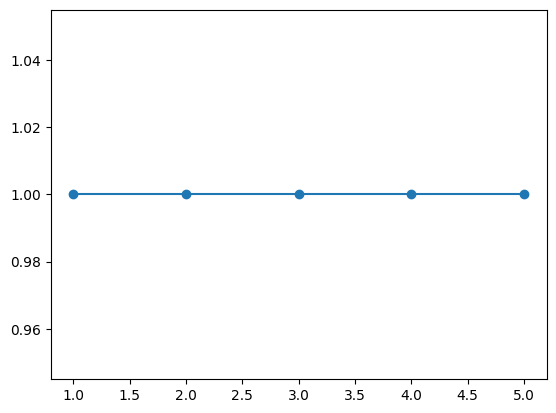

In [ ]:

random_z_exp = measure_z_expectations(random_circuit, n_qubits)

plt.plot(range(1, n_qubits + 1), random_z_exp, 'o-')

### Task 9: Explore other settings

Explore other initial states or monitor the energy (the expectation value of the Hamiltonian) along the dissipative time evolution. What would you expect? How should this be different from the Hamiltonian simulation scenario of `notebooks/hamiltonian_simulation.ipynb`?

In [71]:
def get_xxz_chain_hamiltonian_with_system(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit("system", e[0]), Qubit("system", e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit("system", e[0]), Qubit("system", e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit("system", e[0]), Qubit("system", e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0

    return QubitPauliOperator(qpo_dict)


In [72]:
from pytket.circuit import StatePreparationBox

xxz_hamiltonian__ = get_xxz_chain_hamiltonian_with_system(n_qubits, 0.5)

xxz_ham_matrix = xxz_hamiltonian__.to_sparse_matrix().todense()
eigenvalues, eigenvectors = np.linalg.eig(xxz_ham_matrix)

idx = eigenvalues.argsort()
state1 = eigenvectors[:, idx[0]]
# state2 = eigenvectors[:, idx[2]]
energy1 = eigenvalues[idx[0]]
# energy2 = eigenvalues[idx[2]]
# energy_difference = abs(energy2 - energy1)
state1 = np.real_if_close(state1)
# state2 = np.real_if_close(state2)

state1 = state1 / np.linalg.norm(state1)
# state2 = state2 / np.linalg.norm(state2)

circuit = Circuit(n_system_qubits)
state_prep_box = StatePreparationBox(state1)
circuit.add_state_preparation_box(state_prep_box, list(range(n_qubits)))

times = np.linspace(0, 20, 7)
# observable = QubitPauliOperator({QubitPauliString([Qubit(0)], [Pauli.X]) : 1.0})


# exp_energy = xxz_simulator.get_energy_time_evolution(times, observable, n_shots=10)


RuntimeError: 4 args provided, but StatePreparationBox requires 5

In [73]:
energies = []

for t in times:
    sim_circuit = XXZ_lindblad_simulation_circ(
        n_system_qubits=n_qubits,
        Delta_ZZ=0.5,
        epsilon=0.2,
        t_evolution=t,
        n_evolution_steps=10,
    )

    exp_energy = get_operator_expectation_value(sim_circuit, xxz_hamiltonian__, noise_backend, n_shots=10)
    print(exp_energy)
    energies.append(exp_energy)
    # z_expectations = measure_z_expectations(sim_circuit, n_qubits)

(2.5999999999999996+0j)
(1.3+0j)
(0.20000000000000007+0j)
(0.3+0j)
(0.6000000000000002+0j)
(1.0999999999999996+0j)
(-0.8999999999999999+0j)


/Users/rohan/Developer/hack/iquhack/2025-Quantinuum/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/rohan/Developer/hack/iquhack/2025-Quantinuum/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


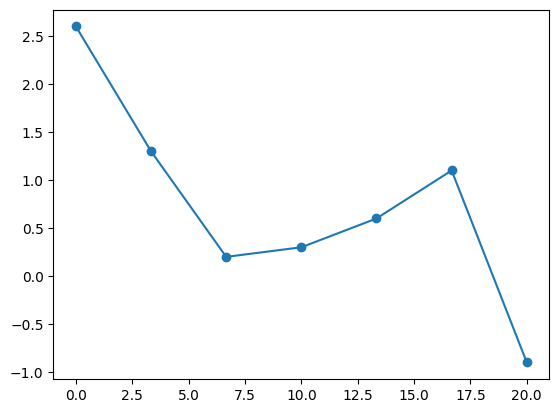

In [74]:
plt.plot(times, energies, 'o-')

### Task 10: Other dissipative systems

Study the models and use-cases considered in [6,7].

### Task 11: Classical simulation

Develop, apply or improve classical computational methods, e.g. tensor network or quantum jump and Monte Carlo solvers (see e.g. qutip), to simulate open system dynamics.

In [138]:
import scipy
def pauli_matrices():
    I = np.array([[1, 0], [0, 1]], dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    return I, X, Z

def kron_n(matrices):
    """Compute the Kronecker product of a list of matrices."""
    result = np.array([[1]], dtype=complex)
    for m in matrices:
        result = np.kron(result, m)
    return result


def initial_state(N):
    psi0 = np.zeros(2**N, dtype=complex)
    psi0[0] = 1.0
    return psi0

cur_hamiltonian = get_xxz_chain_hamiltonian(4, 0.5)
H = cur_hamiltonian.to_sparse_matrix().todense()
print(H.shape)
def classical(N, t_val):
    # H_full = build_full_hamiltonian(N, t_val)
    U_exact = scipy.linalg.expm(-1j * H * t_val)
    psi0 = initial_state(N)
    psi_exact = U_exact @ psi0
    # print(psi_exact.shape)
    final = H @ psi_exact
    # print(final.shape)
    # print(final @ psi_exact)
    # conj_t = np.atleast_2d(psi_exact).conj()
    # print(np.atleast_2d(psi_exact).conj() @ final.T)
    # np.flatten(np.atleast_2d(psi_exact).conj() @ final.T)
    # res = (np.atleast_2d(psi_exact).conj() @ final.T).squeeze()
    # print(res.shape)
    # print(res.item())
    return (np.atleast_2d(psi_exact).conj() @ final.T).item()
    # return psi_exact

(16, 16)


/Users/rohan/Developer/hack/iquhack/2025-Quantinuum/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/rohan/Developer/hack/iquhack/2025-Quantinuum/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


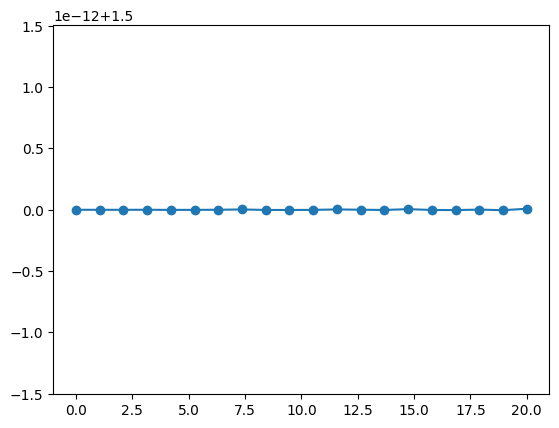

In [139]:
times = np.linspace(0, 20, 20)
energies = [classical(4, t) for t in times]
plt.plot(times, energies, 'o-')
